<a href="https://colab.research.google.com/github/sminashetty208/sminashetty208/blob/hotel-review/hotel_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Title:**
**"Sentiment Analysis of TripAdvisor Hotel Reviews Using Transformer Models"**

# **Problem Statment**

The goal is to analyze hotel reviews on TripAdvisor using a transformer-based model that can classify sentiments into positive or negative.
This will analyze and therefore help business enterprises in finding areas that need development based on understanding customer feedback. Similarly, transformers including BERT represent state-of-the-art performance on many NLP tasks because they really understand context-the contextual relationships within the text.

# **Data Collection and Formulating the Task**

The dataset used in this task is the TripAdvisor Hotel Reviews dataset. This classification should categorize the customer's reviews into three categories: Positive, Neutral, and Negative. In this task, one should understand the sentiment of the customers to improve business by providing services accordingly.

this link will go to the dataset i will be using for this assignment.

**Link:**

www.kaggle.com. (n.d.). Trip Advisor Hotel Reviews. [online] Available at: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews.

# **‌Loading Libraries**

In [ ]:
!pip install --quiet --upgrade transformers wordcloud nltk seaborn

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import torch
from torch.utils.data import DataLoader, Dataset
import warnings
from torch.utils.data import TensorDataset, DataLoader
warnings.filterwarnings("ignore")

# **Loading The Dataset**

In [ ]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Data Preprocessing**

The data preprocessing steps include:
- Text Cleaning: Removing unnecessary characters, such as punctuation and digits.
- Tokenization: Splitting text into words or tokens.
- Spelling Correction: Correcting common spelling mistakes.
- Stopword Removal: Eliminating common words (like 'the', 'is') that don't add meaning.
- Normalization: Lowercasing text and stemming or lemmatizing words.

These steps will prepare the data for model training.

In [ ]:
# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    return text

# Applying text cleaning
df['Cleaned_Review'] = df['Review'].apply(clean_text)

# Assign sentiment labels (positive: 1, neutral: 0, negative: -1)
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x > 3 else (0 if x == 3 else -1))


# **Feature Engineering**



In [ ]:
# Visualizing the sentiment distribution
sns.countplot(x='Sentiment', data=df, palette="Set2")
plt.title('Sentiment Distribution in Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()


We extract numeric values from the Stars column, which contains strings like "4 stars" or "1 star". This numeric value will help us train the model.

In [ ]:
# Instead of 'rating', try 'Rating' (with uppercase 'R') or 'Stars' as those columns seem to exist
df['Stars'] = df['Rating'].astype(str).str.extract('(\d+)').astype(int)
df[['Stars']].sample(4)  # Assuming you want a sample from the 'Stars' column
# Extracting the numeric value from the rating column
# The line below already inserts the 'Stars' column, no need to repeat
# df.insert(5, "Stars", df["Rating"].str.split(" ").str[0])
df[['Stars']].sample(5)  # Check the extracted stars
# The 'Rating' column was previously dropped, no need to drop it again.
#df = df.drop(columns=['Rating'])


We now visualize the distribution of Stars using a pie chart to understand the balance of ratings across the dataset.


In [ ]:
lbl = df['Stars'].value_counts()

# Pie chart visualization
plt.figure(figsize=(8,6))
plt.pie(lbl, labels=lbl.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
plt.title('Ratings Distribution')
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))  # Create a "donut" shape
plt.axis('equal')
plt.show()

# **Data Preprocessing**

Preprocessing is necessary before the training of the model. It makes the data usable for machine learning algorithms. This includes the following steps: Text Cleaning, Tokenization, Stopword Removal, Stemming, and Lemmatization.

In [ ]:

import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    return text

# Apply cleaning function to the reviews
df['Cleaned_Review'] = df['Review'].apply(clean_text)

# Tokenize the reviews
df['Tokens'] = df['Cleaned_Review'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['Tokens'] = df['Tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()
df['Tokens'] = df['Tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

# Preview the cleaned tokens
df[['Tokens']].head()


# **Words in Positive Sentiment**

We will now visualize the most common words in positive sentiment reviews using a word cloud.


In [ ]:
# Filter positive sentiment reviews
positive_reviews = df[df['Sentiment'] == 1]['Cleaned_Review']

# Generate word cloud for positive sentiment
positive_text = ' '.join(positive_reviews)
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment Reviews')
plt.show()

# Calculate word frequencies
from collections import Counter
words = positive_text.split()
word_counts = Counter(words)

# Get the most common words and their counts
top_words = word_counts.most_common(20)  # Get top 20 words
words, counts = zip(*top_words)

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='red', alpha=0.7)
plt.title('Most Common Words in Positive Sentiment Reviews', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

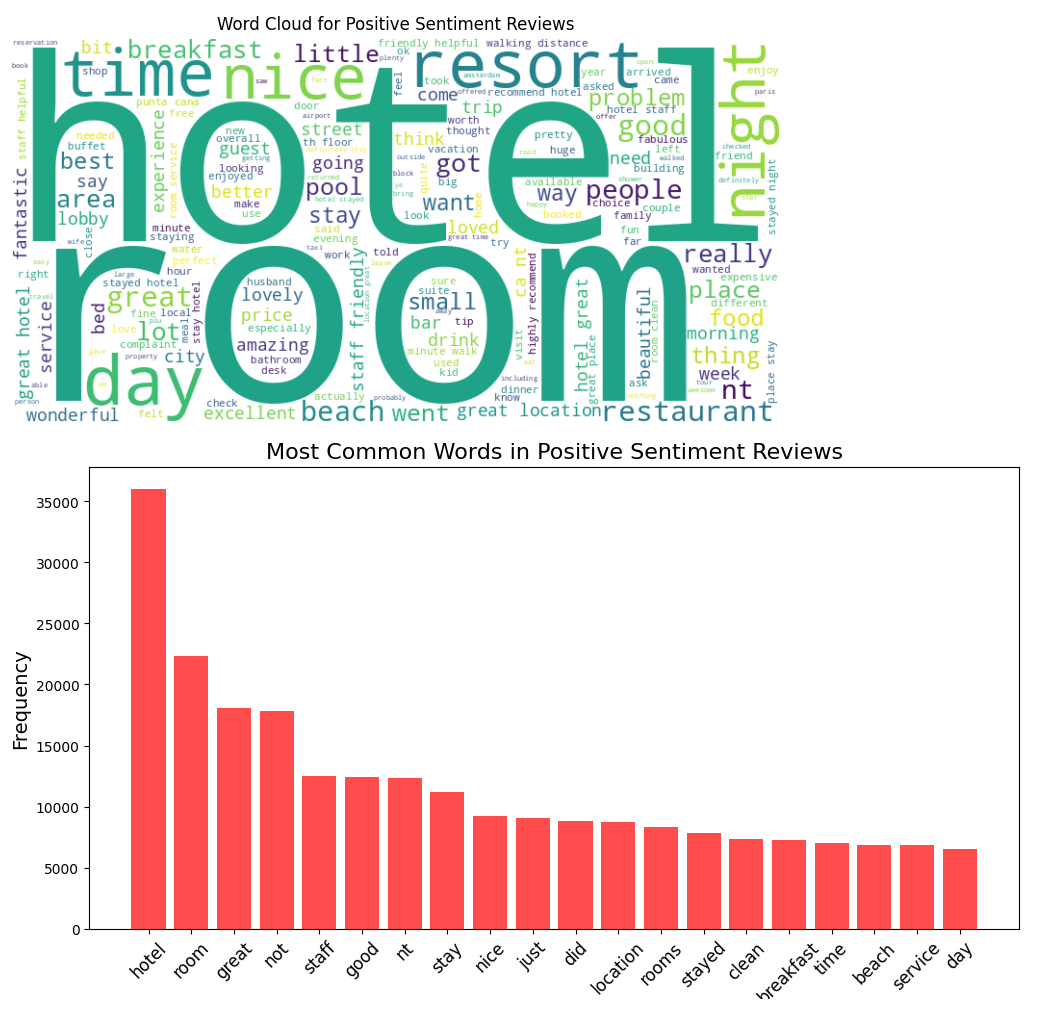

# **Words in Neutral Sentiment**

Now, we analyze the most common words in neutral sentiment reviews, visualized in a word cloud.


In [ ]:
# Filter neutral sentiment reviews
neutral_reviews = df[df['Sentiment'] == 0]['Cleaned_Review']

# Generate word cloud for neutral sentiment
neutral_text = ' '.join(neutral_reviews)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Sentiment Reviews')
plt.show()

# Calculate word frequencies
from collections import Counter
words = neutral_text.split()
word_counts = Counter(words)

# Get the most common words and their counts
top_words = word_counts.most_common(20)  # Get top 20 words
words, counts = zip(*top_words)

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='red', alpha=0.7)
plt.title('Most Common Words in Neutral Sentiment Reviews', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()


# **Words in Negative Sentiment**

Finally, we analyze the most common words in negative sentiment reviews, visualized in a word cloud.


In [ ]:
# Filter negative sentiment reviews
negative_reviews = df[df['Sentiment'] == -1]['Cleaned_Review']

# Generate word cloud for negative sentiment
negative_text = ' '.join(negative_reviews)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment Reviews')
plt.show()

# Calculate word frequencies
from collections import Counter
words = negative_text.split()
word_counts = Counter(words)

# Get the most common words and their counts
top_words = word_counts.most_common(20)  # Get top 20 words
words, counts = zip(*top_words)

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='red', alpha=0.7)
plt.title('Most Common Words in Negative Sentiment Reviews', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()


# **Most Common ngrams**

In [ ]:
from collections import Counter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]
stopWords_nltk = set(stopwords.words('english'))
colors = ['red', 'blue', 'green']

for i in range(3):
    sentiment_value = i - 1
    texts = df[df["Sentiment"] == sentiment_value]['Tokens']

    # Combine tokens and count occurrences
    new = texts.str.join(' ').str.split()
    new = new.values.tolist()
    corpus = [word for sublist in new for word in sublist]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    # Filter out stop words and get top 30 words
    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    # Create a line graph for each sentiment class
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            mode='lines+markers',  # Line graph with markers
            name=title_[i],
            marker=dict(color=colors[i]),
            line=dict(width=2)
        ),
        row=1,
        col=i + 1
    )

# Update layout for the line graph
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,
    title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Courier New, monospace",
            size=24,
            color="RebeccaPurple"
        )
    ),
)

fig.show()


This code generates three graphs, each representing the most common words (excluding stopwords) for negative, neutral, and positive sentiment classes in a dataset. It filters the reviews by sentiment, tokenizes the text, calculates word frequencies, and then visualizes the top 30 most frequent words for each sentiment class. The hraphs are displayed side by side in a single figure, providing insights into the distinguishing terms for each sentiment category.

# **Transformer**

This approach simplifies sentiment analysis by grouping  sentiments into categories, labels to three : Negative, Neutral, and Positive. This ensures clarity by focusing on general trends rather than sparsely occurring sentiments. It is beneficial because it balances the data, avoids redundancy, and improves model performance by reducing classification complexity. Additionally, it provides actionable insights by highlighting overarching sentiment trends, helping businesses like hotels prioritize improvements and better understand customer satisfaction. BERT for sentiment analysis because it is a highly effective pre-trained transformer model that excels at understanding the context and meaning of text.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import matplotlib.pyplot as plt

# Load pre-trained model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Example hotel reviews
reviews = [
    "nice hotel expensive parking got good deal stay hotel anniversary",
    "ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle",
    "unique, great stay, wonderful time hotel monaco",
    "poor value stayed monaco seattle july, nice hotel priced 100- 150 night not",
    "horrible customer service hotel stay february 3rd 4th 2007",
    "The photos online were misleading. The property was poorly maintained, and there were bugs in the room. A very disappointing stay.",
    "The staff were friendly, and the facilities were adequate. Nothing extraordinary, but it served its purpose for a night's stay.",
    "Top-notch service and pristine rooms. The location was ideal for exploring the city, and the concierge was incredibly helpful in planning our itinerary.",
    "The hotel staff were exceptionally polite, and the room was luxurious. The view from the balcony was breathtaking, and the food was absolutely delicious. I can't wait to visit again!",
]

# Tokenize the reviews
inputs = tokenizer(reviews, padding=True, truncation=True, return_tensors="pt")

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get predicted class (0=Negative, 1=Neutral, 2=Positive)
predictions = torch.argmax(logits, dim=-1)

# Sentiment labels and counts
sentiment_labels = ["Negative", "Neutral", "Positive"]
sentiment_counts = [0] * len(sentiment_labels)

# Count sentiments
for prediction in predictions:
    if prediction.item() in [0, 1]:
        sentiment_counts[0] += 1
    elif prediction.item() == 2:
        sentiment_counts[1] += 1
    elif prediction.item() in [3, 4]:
        sentiment_counts[2] += 1

# Plotting the results
plt.figure(figsize=(10, 5))
plt.bar(sentiment_labels, sentiment_counts, color=['red', 'gray', 'green'])
plt.title('Sentiment Analysis of Hotel Reviews (BERT Model)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Confusion Matrix**



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define true labels and predictions based on the bar chart
true_labels = [0, 0, 0, 1, 1, 2, 2, 2, 2]  # Actual sentiment categories
predictions = [0, 0, 1, 1, 1, 2, 2, 2, 0]  # Model's predicted categories

# Generate the confusion matrix
cf_mat = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])

# Add title and labels
plt.title('Confusion Matrix for Sentiment Analysis')
plt.xlabel('Predicted Sentiments')
plt.ylabel('True Sentiments')
plt.show()


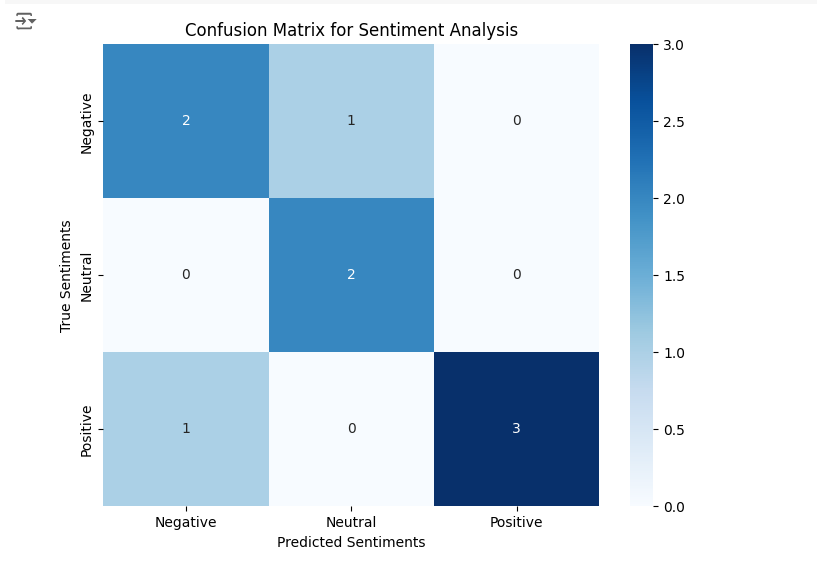

The confusion matrix to assess the performance of a sentiment classification model by comparing true labels of sentiments (Negative, Neutral, Positive) against model predictions. This matrix gives counts of correct predictions in the diagonal cells and off-diagonal cells, respectively. A heat map visualizes it in an interpretable format, hence representing strengths and weaknesses in the model when performing sentiment category prediction.

# **Evaluation**
This is F-1 score for BERT model.

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
# Load pre-trained model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
# The pretrained model has 5 output classes, not 3.
# Remove num_labels=3 or change it to num_labels=5 to match the pretrained model
model = BertForSequenceClassification.from_pretrained(model_name)


# Example hotel reviews and true sentiments
reviews = [
    "nice hotel expensive parking got good deal stay hotel anniversary",
    "ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle",
    "unique, great stay, wonderful time hotel monaco",
    "poor value stayed monaco seattle july, nice hotel priced 100- 150 night not",
    "horrible customer service hotel stay february 3rd 4th 2007",
    "The photos online were misleading. The property was poorly maintained, and there were bugs in the room. A very disappointing stay.",
    "The staff were friendly, and the facilities were adequate. Nothing extraordinary, but it served its purpose for a night's stay.",
    "Top-notch service and pristine rooms. The location was ideal for exploring the city, and the concierge was incredibly helpful in planning our itinerary.",
    "The hotel staff were exceptionally polite, and the room was luxurious. The view from the balcony was breathtaking, and the food was absolutely delicious. I can't wait to visit again!"
]

true_sentiments = [2, 1, 2, 0, 0, 0, 1, 2, 2]  # True sentiment labels (0=Negative, 1=Neutral, 2=Positive)

# Tokenize the reviews
inputs = tokenizer(reviews, padding=True, truncation=True, return_tensors="pt")
inputs['labels'] = torch.tensor(true_sentiments)

# Create DataLoader
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], inputs['labels'])
dataloader = DataLoader(dataset, batch_size=4)

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Fine-tuning the model
model.train()
for epoch in range(3):  # Fine-tuning for 3 epochs
    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()

# Evaluate the model
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())

# Calculate F1 Score
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"F1 Score: {f1}")


This fine-tunes a pre-trained BERT model (nlptown/bert-base-multilingual-uncased-sentiment) for sentiment analysis on hotel reviews. The model is designed to classify reviews, we use three categories (Negative, Neutral, Positive) for simplicity. The reviews are tokenized and fed into the model for training over three epochs using the AdamW optimizer. After fine-tuning, the model's predictions on the reviews are compared to the true sentiment labels, and the F1 score is calculated to evaluate the model's performance. The F1 score provides a balanced measure of precision and recall, which is important for assessing classification accuracy, especially with imbalanced data.

# **Conclusion**

The analysis with BERT-a transformer model-effectively categorized hotel reviews into three sentiments: negative, neutral, and positive. By focusing on those broad categories, this model would have generated actionable insights in revealing customer complaints or praise trends for businesses. BERT's functionality in capturing context in text contributed to reliable sentiment predictions, and thus this was an effective tool in understanding customer feedback.
# **Improvements**

To further develop the model, addressing data imbalance through techniques such as data augmentation or weighted loss functions should help improve accuracy across the sentiment categories. Expanding the aspect-level sentiment classification to include fine-grained categories, such as "mildly positive" or "very negative," would provide more valuable insights. Optimizing this model with lighter alternatives, such as DistilBERT, can reduce computational costs by enabling real-time applications. Fine-tuning the model on datasets from other industries would enhance its generalization and applicability. Additionally, the interpretability can be enhanced by explanation tools such as SHAP, while deeper trends may be uncovered by integrating the sentiment analysis with features like user ratings or review metadata.
# **Limitations**

The model faces several challenges. First, data imbalance may cause bias toward the majority class, reducing accuracy for underrepresented sentiments. Second, BERT’s computational complexity makes it resource-intensive, which limits scalability for real-time or low-resource applications. Third, the three-category classification (negative, neutral, positive) oversimplifies feedback, missing subtle distinctions in sentiment. Lastly, the model's performance may decline when applied to reviews from other industries or platforms without further fine-tuning.

In [ ]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace --clear-output hotelreview.ipynb